In [21]:
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rollansapyshev/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


Load the dataset

In [12]:
df_train_prompt = pd.read_csv('data/prompts_train.csv')
print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

Full prompt train dataset shape is (4, 4)


In [13]:
df_train_prompt.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [14]:
df_train_summaries = pd.read_csv('data/summaries_train.csv')
print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

Full summaries train dataset shape is (7165, 5)


In [15]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')
print("Full summaries train dataset shape is {}".format(df_train.shape))

Full summaries train dataset shape is (7165, 8)


In [16]:
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


Label data distribution

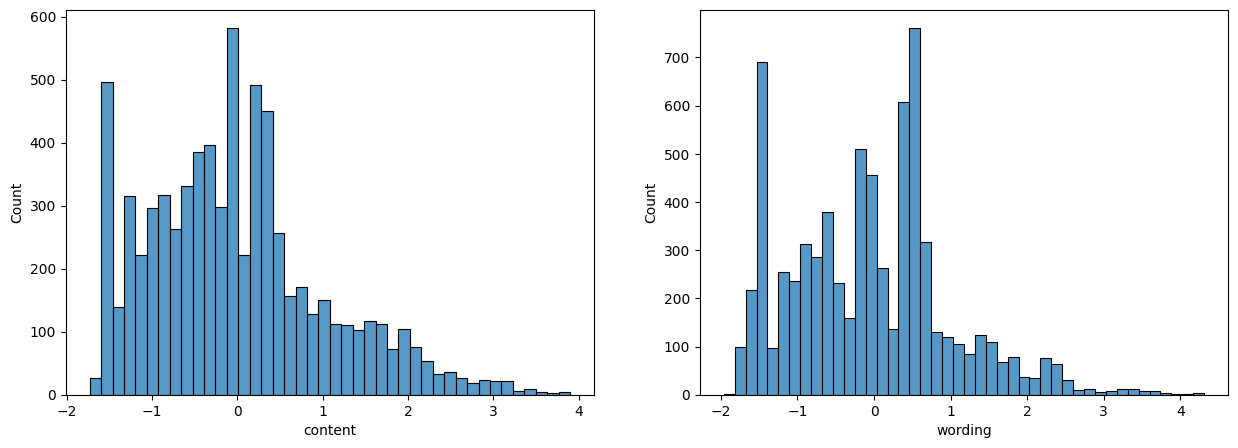

In [17]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='wording')
plt.show()

In [18]:
# Reference: https://www.kaggle.com/code/sercanyesiloz/commonlit-tf-idf-xgb-baseline#4.-Feature-Engineering

# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, 
# both when indexing entries for searching and when retrieving them as the result of a search query.
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [22]:
preprocessed_df = feature_engineer(df_train)
print("Full summaries train dataset shape is {}".format(preprocessed_df.shape))

Full summaries train dataset shape is (7165, 13)


In [24]:
FEATURE_COLUMNS = preprocessed_df.drop(columns = ['student_id', 'prompt_id', 'text', 'prompt_question', 
                                           'prompt_title', 'prompt_text', 'content', 'wording'], axis = 1).columns.to_list()

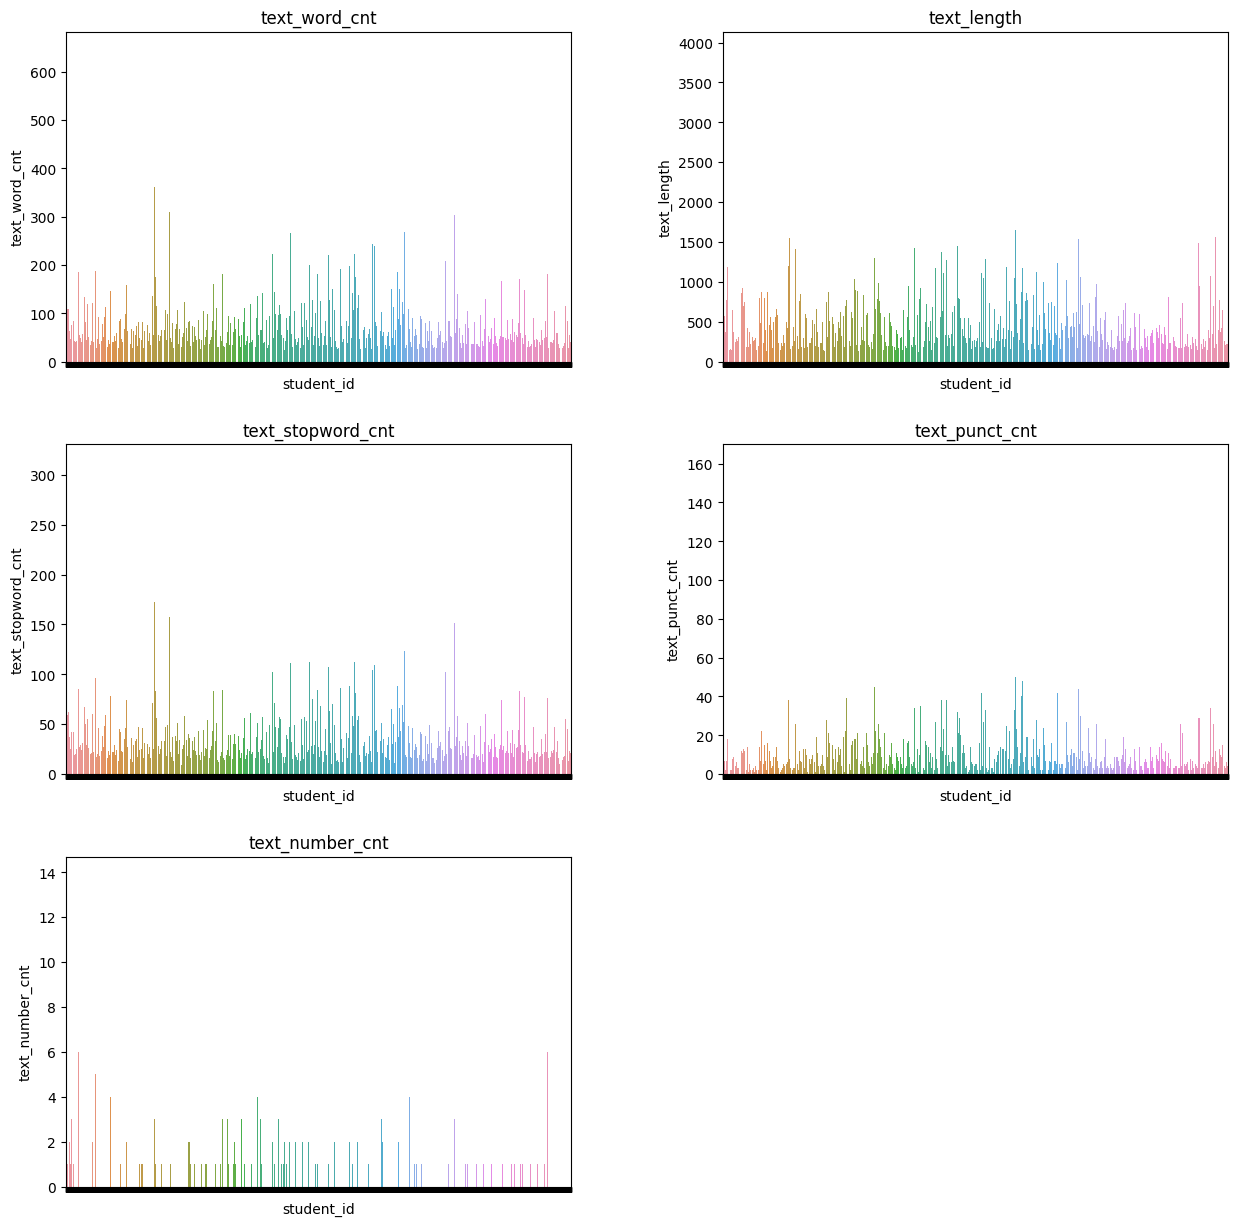

In [25]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(FEATURE_COLUMNS):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=preprocessed_df['student_id'], y=preprocessed_df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)
axis[2, 1].set_visible(False)
plt.show()

In [26]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(preprocessed_df)
train_ds_pd.shape, valid_ds_pd.shape

((5795, 13), (1370, 13))

In [27]:
# `content` label datatset columns
FEATURE_CONTENT = FEATURE_COLUMNS + ['content']

# `wording` label datatset columns
FEATURE_WORDING = FEATURE_COLUMNS + ['wording']

# Convert dataframes to corresponding datasets
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_CONTENT], label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_WORDING], label='wording', task = tfdf.keras.Task.REGRESSION)

Select model

In [28]:
tfdf.keras.get_all_models

<function tensorflow_decision_forests.keras.get_all_models() -> List[Callable[[], tensorflow_decision_forests.keras.core.CoreModel]]>

In [29]:
# Create RandomForestModel for label content
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

# Create RandomForestModel for label wording
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])

Use /var/folders/53/zdvtpqvs6qxf5ht0lhmgw37c0000gp/T/tmp4iizon4m as temporary training directory
Use /var/folders/53/zdvtpqvs6qxf5ht0lhmgw37c0000gp/T/tmpchu187ob as temporary training directory


In [30]:
# Training RandomForestModel for label content
model_content.fit(x=content_train_ds)

# Training RandomForestModel for label wording
model_wording.fit(x=wording_train_ds)

Reading training dataset...
Training dataset read in 0:00:01.558984. Found 5795 examples.
Training model...


[INFO 23-08-30 12:01:10.1672 +06 kernel.cc:1243] Loading model from path /var/folders/53/zdvtpqvs6qxf5ht0lhmgw37c0000gp/T/tmp4iizon4m/model/ with prefix fe65383e2ddd40f5


Model trained in 0:00:01.369671
Compiling model...


[INFO 23-08-30 12:01:10.8575 +06 decision_forest.cc:660] Model loaded with 300 root(s), 466542 node(s), and 5 input feature(s).
[INFO 23-08-30 12:01:10.8576 +06 abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-08-30 12:01:10.8576 +06 kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.093617. Found 5795 examples.
Training model...


[INFO 23-08-30 12:01:12.3365 +06 kernel.cc:1243] Loading model from path /var/folders/53/zdvtpqvs6qxf5ht0lhmgw37c0000gp/T/tmpchu187ob/model/ with prefix b45c6547a8974b27


Model trained in 0:00:01.313723
Compiling model...
Model compiled.


[INFO 23-08-30 12:01:12.9993 +06 decision_forest.cc:660] Model loaded with 300 root(s), 450430 node(s), and 5 input feature(s).
[INFO 23-08-30 12:01:12.9993 +06 kernel.cc:1075] Use fast generic engine


In [31]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_content, tree_idx=0, max_depth=3)

In [32]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_wording, tree_idx=0, max_depth=3)

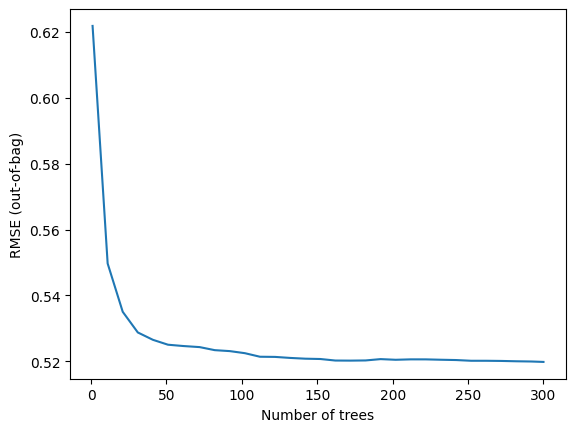

In [33]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

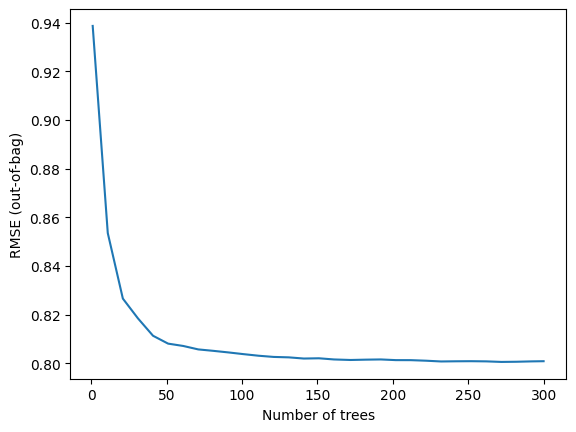

In [34]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [35]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5795, accuracy=None, loss=None, rmse=0.519826648353973, ndcg=None, aucs=None, auuc=None, qini=None)

In [36]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5795, accuracy=None, loss=None, rmse=0.8008383783814876, ndcg=None, aucs=None, auuc=None, qini=None)

In [37]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_CONTENT], label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_WORDING], label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - mse: 0.3016
loss: 0.0000
mse: 0.3016
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mse: 0.6178
loss: 0.0000
mse: 0.6178


In [38]:
print(f"Available variable importances for model_content:")
for importance in inspector_content.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_content:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [39]:
print(f"Available variable importances for model_wording:")
for importance in inspector_wording.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_wording:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [40]:
# For model_content.
# Each line is: (feature name, (index of the feature), importance score)
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 185.0),
 ("text_word_cnt" (1; #5), 89.0),
 ("text_stopword_cnt" (1; #4), 26.0)]

In [41]:
# For model_wording.
# Each line is: (feature name, (index of the feature), importance score)
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 187.0),
 ("text_word_cnt" (1; #5), 81.0),
 ("text_stopword_cnt" (1; #4), 32.0)]

Submission

In [42]:
df_test_prompt = pd.read_csv('data/prompts_test.csv')
df_test_summaries = pd.read_csv('data/summaries_test.csv')

In [43]:
df_test = df_test_summaries.merge(df_test_prompt, on='prompt_id')

In [44]:
processed_test_df = feature_engineer(df_test)

In [45]:
processed_test_df.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1


In [46]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(processed_test_df[FEATURE_COLUMNS], task = tfdf.keras.Task.REGRESSION)

In [47]:
processed_test_df['content'] = model_content.predict(test_ds)
processed_test_df['wording'] = model_wording.predict(test_ds)

1/1 [==============================] - 0s 18ms/step


In [49]:
processed_test_df[['student_id', 'content', 'wording']].to_csv('data/results/submission.csv',index=False)
display(pd.read_csv('data/results/submission.csv'))

,student_id,content,wording
0,000000ffffff,-1.344332,-1.431068
1,222222cccccc,-1.344332,-1.431068
2,111111eeeeee,-1.344332,-1.431068
3,333333dddddd,-1.344332,-1.431068
